#Setup

## Packages

In [3]:
%pip install -qq google-api-python-client
%pip install -qq torch torchvision
%pip install -qq retry
%pip install -qq google-auth

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-storage 1.31.0 requires google-auth<2.0dev,>=1.11.0, but you have google-auth 2.17.3 which is incompatible.
google-cloud-core 1.7.1 requires google-api-core<2.0.0dev,>=1.21.0, but you have google-api-core 2.11.0 which is incompatible.
google-cloud-core 1.7.1 requires google-auth<2.0dev,>=1.24.0, but you have google-auth 2.17.3 which is incompatible.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install -qq google-auth-oauthlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import os

creds = None
token_path = 'token.json'
creds_path = 'creds.json'
SCOPES = ['https://www.googleapis.com/auth/devstorage.read_only']

if os.path.exists(token_path):
    creds = Credentials.from_authorized_user_file(token_path, SCOPES)

if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            creds_path, SCOPES)
        creds = flow.run_local_server(port=0)
    
    with open(token_path, 'w') as token:
        token.write(creds.to_json())

## Dataset

#### Bounding Boxes Dataset

In [3]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms.v2 as v2
from torchvision.transforms.v2 import ToTensor

from PIL import Image
from copy import copy
import pandas as pd
import json
import os

from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from requests.exceptions import SSLError
from retry import retry
from io import BytesIO

gcs_service = build('storage', 'v1', credentials=creds)

class SerengetiBBoxDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, root, images_path, bboxes_path, classes_path, seasons=None, transform=ToTensor()):
        self.root = root
        self.transform = transform
        self.seasons = seasons

        images_df = pd.read_csv(images_path)
        
        with open(bboxes_path, 'r') as f:
            self.bbox_objects = json.load(f)['annotations']
        
        with open(classes_path, 'r') as f:
            class_objects = json.load(f)['categories']
        
        self.classes = {obj['name'].lower(): obj['id'] for obj in class_objects}
        self.images = images_df['image_path_rel'].tolist()
        if self.seasons:
            self.images = list(filter(self.filter_seasons, self.images)) # filter out seasons
        self.labels = []
        self.bboxes = [[] for _ in range(len(self.images))]

        for species in images_df['question__species'].tolist():
            species = species.lower()
            if species == 'blank':
                species = 'empty'
            if species == 'vervetmonkey':
                species = 'monkeyvervet'
            self.labels.append(self.classes[species])
        
        image_dict = {filename: i for i, filename in enumerate(self.images)}

        for obj in self.bbox_objects:
            image = obj['image_id'] + '.JPG'
            if image in image_dict:
                bbox = obj['bbox']
                index = image_dict[image]
                self.bboxes[index].append(bbox)

        i = 0
        while i < len(self.bboxes):
            if len(self.bboxes[i]) == 0:
                del self.images[i]
                del self.bboxes[i]
            else:
                i += 1
        
    def __getitem__(self, i):
        # Read Image
        path = os.path.join(self.root, self.images[i])
        # image = Image.open(path, mode='r')
        image = self.request_image_from_gcs(path)
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels)
        boxes = torch.FloatTensor(self.bboxes[i])               # (n_objects, 4)
        labels = torch.LongTensor([self.labels[i]]*len(boxes))  # (n_objects), all objects are same label

        if self.transform:
            image, boxes, labels = self.transform(image, boxes, labels)

        return image, boxes, labels

    @retry(exceptions=SSLError, tries=10, delay=1)
    def request_image_from_gcs(self, image_path):
        bucket_name = 'public-datasets-lila'
        image_bytes = BytesIO()
        request = gcs_service.objects().get_media(bucket=bucket_name, object=image_path)
        media = MediaIoBaseDownload(image_bytes, request)

        done = False
        while not done:
            _, done = media.next_chunk()

        image_bytes.seek(0)

        return Image.open(image_bytes)

        
    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        images = list()
        boxes = list()
        labels = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim=0)

        return images, boxes, labels  # tensor (N, 3, x, y), 3 lists of N tensors each

    def filter_seasons(self, image):
        for season in self.seasons:
            if season + '/' in image:
                return True
        return False

C:\Users\rb1578\AppData\Roaming\Python\Python39\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


#### Custom Transformations

In [4]:
# @title ###### Absolute to Fractional Boxes

import torchvision.transforms.functional as TF
import torchvision.transforms.v2 as transforms
import random
import numpy as np

class BBoxToFractional(object):
    def __call__(self, sample):
        """
            returns: new bounding box in fractional format (ie cx cy w h)
        """
        image, boxes, labels = sample
        fractional_boxes = torch.FloatTensor(len(boxes), 4)
        for i, box in enumerate(boxes):
            x, y, w, h = box
            fractional_boxes[i] = torch.Tensor([
                x + (w / 2), 
                y + (w / 2), 
                w / 2, 
                h / 2
            ])

        return image, fractional_boxes, labels

In [5]:
# @title ##### Random Crop

import torchvision.transforms.functional as TF
import torchvision.transforms.v2 as transforms
import random
import numpy as np

class BBoxRandomCrop(object):
    def __init__(self, scale, ratio):
        assert isinstance(scale, tuple)
        self.scale = scale
        assert isinstance(ratio, tuple)
        self.ratio = ratio

    def __call__(self, sample):
        success = False
        attempts = 0
        image, boxes, labels = copy(sample)

        while not success and attempts < 20:
            # Randomly determine the scale and ratio of the crop
            scale = random.uniform(self.scale[0], self.scale[1])
            ratio = random.uniform(self.ratio[0], self.ratio[1])

            # Get the height and width of the input image
            h, w = image.height, image.width

            # Calculate the maximum crop dimensions
            cropped_h_max = h
            cropped_w_max = w
            if ratio > 0:
                cropped_w_max = int(cropped_h_max / ratio)
            if cropped_w_max > w:
                cropped_w_max = w
                cropped_h_max = int(cropped_w_max * ratio)

            # Calculate the actual crop dimensions based on the scale
            area_ratio = np.sqrt(scale)
            cropped_h = int(cropped_h_max * area_ratio)
            cropped_w = int(cropped_w_max * area_ratio)

            # Randomly determine the top-left coordinates of the crop
            top = np.random.randint(0, h - cropped_h) if h > cropped_h else 0
            left = np.random.randint(0, w - cropped_w) if w > cropped_w else 0

            # Calculate the bottom-right coordinates of the crop
            right = min(w, left + cropped_w)
            bottom = min(h, top + cropped_h)

            # Crop the image and convert to PIL format
            image = TF.to_tensor(image)
            image = image[:, top: bottom, left: right]
            image = TF.to_pil_image(image)

            updated_boxes = torch.Tensor(len(boxes), 4)
            # If the center is off screen, set it to empty
            for i, box in enumerate(boxes):
                updated_boxes[i] = self.crop_bbox(box, (top, left))

            updated_labels = labels
            for i, (x,y,_,_) in enumerate(boxes):
                if x <= 0 or y <= 0 or x >= cropped_w or y >= cropped_h:
                    updated_labels[i] = 0

            updated_boxes = updated_boxes[updated_labels != 0]
            updated_labels = updated_labels[updated_labels != 0]
            
            if len(updated_boxes) > 0:
                success = True
                labels = updated_labels
                boxes = updated_boxes
            else:
                image, boxes, labels = copy(sample)
                attempts += 1

        return image, boxes, labels
    
    def crop_bbox(self, bbox, crop):
        top, left = crop
        x, y, w, h = copy(bbox)
        x = bbox[0] - left
        y = bbox[1] - top
        return torch.Tensor([x,y,w,h])

In [6]:
# @title ##### Random Horizontal Flip

import torchvision.transforms.functional as TF
import torchvision.transforms.v2 as transforms
import random
import numpy as np

class BBoxRandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        assert isinstance(p, float)
        self.p = p

    def __call__(self, sample):
        image, bboxes, labels = sample
        flip = random.random() <= self.p
        if flip:
            image = TF.hflip(image)
            bboxes = [self.bbox_hflip(image.width, bbox) for bbox in bboxes]
            bboxes = torch.stack(bboxes)
        return image, bboxes, labels


    def bbox_hflip(self, width, bbox):
        bbox[0] = width - bbox[0]
        return bbox

In [7]:
# @title ##### Resize

class BBoxResize(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, bboxes, labels = sample
        h, w = image.height, image.width
        new_h, new_w = self.output_size
        image = transforms.Resize((new_h, new_w))(image)
        for i, bbox in enumerate(bboxes):
            x_scale = new_w / w
            y_scale = new_h / h
            bboxes[i][0] *= x_scale
            bboxes[i][1] *= y_scale
            bboxes[i][2] *= x_scale
            bboxes[i][3] *= y_scale
        return image, bboxes, labels

#### DataLoader

##### WRS

In [8]:
import numpy as np
from torch import from_numpy
from collections import Counter
from torch.utils.data import WeightedRandomSampler, DataLoader, random_split

def get_train_loader(train_data, batch_size):
    sample_weights = get_sample_weights(train_data)
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_data), replacement=True)
    loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=1)
    return loader

def get_sample_weights(train_data):
    train_indices = train_data.indices
    train_classes = np.array(train_data.dataset.targets)[train_indices]

    train_class_counts = Counter(train_classes)
    class_weights = Counter(train_class_counts)
    sample_weights = np.array([1/class_weights[t] for t in train_classes])
    return  from_numpy(sample_weights)

## Network


In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.models.detection as detection
import torchvision.models.feature_extraction as feature_extraction
import numpy as np
from copy import copy

### Base Feature Extractor

In [11]:
class Base(nn.Module):
    def __init__(self):
        super(Base, self).__init__()
        efficientnet_b3 = torchvision.models.efficientnet_b3(weights='EfficientNet_B3_Weights.DEFAULT')
        return_nodes = {
            'features.4.0.block.0': "features_38",
            'features.6.0.block.0': "features_19",
            'features.8':           "features_10",
        }
        self.feature_extractor = feature_extraction.create_feature_extractor(efficientnet_b3, return_nodes=return_nodes)

    def forward(self, input):
        features = self.feature_extractor(input)
        features_38 = features['features_38']
        features_19 = features['features_19']
        features_10 = features['features_10']

        return features_38, features_19, features_10

### Auxiliary Network

In [12]:
class AuxiliaryNetwork(nn.Module):
    def __init__(self):
        super(AuxiliaryNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.conv1_1 = nn.Conv2d(1536, 384, kernel_size=1, padding=0)
        self.conv1_2 = nn.Conv2d(384, 768, kernel_size=3, stride=2, padding=1)

        self.conv2_1 = nn.Conv2d(768, 192, kernel_size=1, padding=0)
        self.conv2_2 = nn.Conv2d(192, 384, kernel_size=3, stride=2, padding=1)

        self.conv3_1 = nn.Conv2d(384, 192, kernel_size=1, padding=0)
        self.conv3_2 = nn.Conv2d(192, 384, kernel_size=3, padding=0)
        
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)
        

    def forward(self, features_10):
        # (N, 1535, 10, 10)
        out = self.relu(self.conv1_1(features_10))  # (N, 384, 5, 5)
        out = self.relu(self.conv1_2(out))  # (N, 768, 5, 5)
        features_5 = out  # (N, 768, 5, 5)
       
        out = self.relu(self.conv2_1(features_5))  # (N, 192, 3, 3)
        out = self.relu(self.conv2_2(out))  # (N, 384, 3, 3)
        features_3 = out  # (N, 384, 3, 3)
       
        out = self.relu(self.conv3_1(features_3))  # (N, 192, 1, 1)
        out = self.relu(self.conv3_2(out))  # (N, 384, 1, 1)
        features_1 = out  # (N, 384, 1, 1))

        return features_5, features_3, features_1

### Prediction Convolutions

In [13]:
class PredictionNetwork(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.
    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 prior (default) boxes.
    See 'cxcy_to_gcxgcy' in utils.py for the encoding definition.
    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self, n_classes):
        """
        :param n_classes: number of different types of objects
        """
        super(PredictionNetwork, self).__init__()

        self.n_classes = n_classes

        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {'features_38': 4,
                   'features_19': 6,
                   'features_10': 6,
                   'features_5': 6,
                   'features_3': 4,
                   'features_1': 4}
        # 4 prior-boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_38 = nn.Conv2d(288, n_boxes['features_38'] * 4, kernel_size=3, padding=1)
        self.loc_19 = nn.Conv2d(816, n_boxes['features_19'] * 4, kernel_size=3, padding=1)
        self.loc_10 = nn.Conv2d(1536, n_boxes['features_10'] * 4, kernel_size=3, padding=1)
        self.loc_5 = nn.Conv2d(768, n_boxes['features_5'] * 4, kernel_size=3, padding=1)
        self.loc_3 = nn.Conv2d(384, n_boxes['features_3'] * 4, kernel_size=3, padding=1)
        self.loc_1 = nn.Conv2d(384, n_boxes['features_1'] * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_38 = nn.Conv2d(288, n_boxes['features_38'] * n_classes, kernel_size=3, padding=1)
        self.cl_19 = nn.Conv2d(816, n_boxes['features_19'] * n_classes, kernel_size=3, padding=1)
        self.cl_10 = nn.Conv2d(1536, n_boxes['features_10'] * n_classes, kernel_size=3, padding=1)
        self.cl_5 = nn.Conv2d(768, n_boxes['features_5'] * n_classes, kernel_size=3, padding=1)
        self.cl_3 = nn.Conv2d(384, n_boxes['features_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_1 = nn.Conv2d(384, n_boxes['features_1'] * n_classes, kernel_size=3, padding=1)
                
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, features):
        batch_size = features[0].size(0)

        localization_convolutions = [
            self.loc_38,
            self.loc_19,
            self.loc_10,
            self.loc_5,
            self.loc_3,
            self.loc_1,
        ]

        class_convolutions = [
            self.cl_38,
            self.cl_19,
            self.cl_10,
            self.cl_5,
            self.cl_3,
            self.cl_1,
        ]

        localization_predictions = []
        class_predictions = []
        for l_conv, c_conv, feat in zip(localization_convolutions, class_convolutions, features):
            localization_prediction = l_conv(feat)
            localization_prediction = localization_prediction.permute(0, 2, 3, 1).contiguous()
            localization_prediction = localization_prediction.view(batch_size, -1, 4)
            localization_predictions.append(localization_prediction)

            class_prediction = c_conv(feat)
            class_prediction = class_prediction.permute(0, 2, 3, 1).contiguous()
            class_prediction = class_prediction.view(batch_size, -1, self.n_classes)
            class_predictions.append(class_prediction)

        localizations = torch.cat(localization_predictions, dim=1)
        class_scores = torch.cat(class_predictions, dim=1)
        return localizations, class_scores

### Bounding Box Operations


In [14]:
def find_jaccard_overlap(set_1, set_2):
    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)#

def find_intersection(set_1, set_2):
    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

def boundary_to_center(xy): #xmin, ymin, xmax, ymax -> centerx, centery, width, height
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

def center_to_boundary(cxcy):
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max


def center_to_offsets(cxcy, anchors_cxcy): #cxcy width and height are negative
    return torch.cat([(cxcy[:, :2] - anchors_cxcy[:, :2]) / (anchors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / anchors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h

def offsets_to_center(gcxgcy, anchors_cxcy):
    return torch.cat([gcxgcy[:, :2] * anchors_cxcy[:, 2:] / 10 + anchors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * anchors_cxcy[:, 2:]], 1)  # w, h

### Detection Network

In [15]:
class SSD300(nn.Module):
    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = Base()
        self.aux = AuxiliaryNetwork()
        self.pred = PredictionNetwork(n_classes)

        # Since lower level features (features_38) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 288, 1, 1))  # there are 288 channels in features_38
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.anchor_boxes = self.get_anchor_boxes()

    def forward(self, batch):
        features_38, features_19, features_10 = self.base(batch)

        # Rescale conv4_3 after L2 norm
        norm = features_38.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        features_38 = features_38 / norm  # (N, 512, 38, 38)
        features_38 = features_38 * self.rescale_factors  # (N, 512, 38, 38)

        # Run auxiliary convolutions (higher level feature map generators)
        features_5, features_3, features_1 = self.aux(features_10) 

        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        locs, class_scores = self.pred([features_38, features_19, features_10, features_5, features_3, features_1])  
        
        # (N, 8732, 4), (N, 8732, n_classes)
        return locs, class_scores
    
    def get_anchor_boxes(self):
        resolutions = [38, 19, 10, 5, 3, 1]
        scales = [0.1, 0.2, 0.375, 0.55, 0.725, 0.9]
        aspect_ratios = [
            [1, 2, 1/2],
            [1, 2, 1/2, 3, 1/3],
            [1, 2, 1/2, 3, 1/3],
            [1, 2, 1/2, 3, 1/3],
            [1, 2, 1/2],
            [1, 2, 1/2],
        ]
        
        anchor_boxes = []
        for k, (resolution, scale, ratios) in enumerate(zip(resolutions, scales, aspect_ratios)):
            for i in range(resolution):
                for j in range(resolution):
                    x = (i + 0.5) / resolution
                    y = (j + 0.5) / resolution
                    for ratio in ratios:
                        w = scale * np.sqrt(ratio)
                        h = scale / np.sqrt(ratio)
                        anchor_boxes.append([x, y, w, h])
                        if ratio == 1 : # add in an additional scaled up square box
                            extra_scale = 1.
                            if k + 1 < len(scales):
                                extra_scale = np.sqrt(scale * scales[k + 1])
                            anchor_boxes.append([x, y, extra_scale, extra_scale])

        anchor_boxes = torch.FloatTensor(anchor_boxes).to(device)  # (8732, 4)
        anchor_boxes.clamp_(0, 1)  # (8732, 4)
        return anchor_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        batch_size = predicted_locs.size(0)
        n_anchors = self.anchor_boxes.size(0)
        predicted_scores = nn.functional.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_anchors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            decoded_locs = center_to_boundary(
                offsets_to_center(predicted_locs[i], self.anchor_boxes))  # (8732, 4), these are fractional pt. coordinates

            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            for c in range(1, self.n_classes):
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)
                
                # Non-Maximum Suppression (NMS)

                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                for box in range(class_decoded_locs.size(0)):
                    if suppress[box] == 1:
                        continue
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    suppress[box] = 0

                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

### Loss Function

In [16]:
class MultiBoxLoss(nn.Module):
    def __init__(self, anchor_boxes, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.anchor_boxes = anchor_boxes
        self.anchor_box_boundaries = center_to_boundary(self.anchor_boxes)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def get_IoUs(self, boxes):
        intersections = torch.FloatTensor(len(boxes), len(self.anchor_boxes))
        boxes = boxes/300
        for b in range(len(boxes)):
            for a in range(len(self.anchor_boxes)):
                intersections[b][a] = get_intersection_over_union(box, self.anchor_boxes[a])
        return intersections

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        batch_size = predicted_locs.size(0)
        n_anchors = self.anchor_boxes.size(0)
        n_classes = predicted_scores.size(2)

        assert n_anchors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_anchors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_anchors), dtype=torch.long).to(device)  # (N, 8732)
        
        # For each set of boxes belonging to an image
        for i in range(batch_size):
            scaled_boxes = torch.stack([box/300 for box in boxes[i]])
            n_objects = boxes[i].size(0)
            # overlap is a (objects, anchor_boxes) tensor containing the IoU of each anchor for each object
            # IoU = self.get_IoUs(boxes[i])
            IoU = find_jaccard_overlap(scaled_boxes, self.anchor_boxes)
            IoU_for_each_anchor, object_for_each_anchor = IoU.max(dim=0)  # (8732)

            _, anchor_for_each_object = IoU.max(dim=1)  # (N_o)

            object_for_each_anchor[anchor_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            IoU_for_each_anchor[anchor_for_each_object] = 1.

            label_for_each_anchor = labels[i][object_for_each_anchor]  # (8732)
            label_for_each_anchor[IoU_for_each_anchor < self.threshold] = 0  # (8732)

            true_classes[i] = label_for_each_anchor

            true_locs[i] = center_to_offsets(boxes[i][object_for_each_anchor], self.anchor_boxes)  # (8732, 4)
        positive_anchors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS
        loc_loss = self.smooth_l1(predicted_locs[positive_anchors], true_locs[positive_anchors])  # (), scalar

        # CONFIDENCE LOSS

        n_positives = positive_anchors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_anchors)  # (N, 8732)

        conf_loss_pos = conf_loss_all[positive_anchors]  # (sum(n_positives))

        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_anchors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_anchors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar
        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss

# Training

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [18]:
# @title Epoch
from datetime import datetime

def free_up_memory():
    keys = ['images', 'labels', 'boxes', 'predicted_scores', 'predicted_scores']
    for key in keys:
        if key in globals().keys():
            del globals()[key] 

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()  # training mode enables dropout
    epoch_loss = AverageMeter()
    epoch_time = AverageMeter()
    # Batches
    for i, (images, boxes, labels) in enumerate(train_loader):
        times = {}
        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward pass
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar
        
        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary

        # Update model
        optimizer.step()

        epoch_loss.update(loss.item())
        # Print status
        if i % 10 == 0:
            print(f'Epoch {epoch}\t Batch {i} / {len(train_loader)}\tBatch Loss:\t {epoch_loss.val}\t{(datetime.now() - times["start"]).seconds} seconds')
    free_up_memory()  # free some memory since their histories may be stored
    print(f'Avg Loss:\t {np.mean(epoch_loss.avg)}')
    return model


In [20]:
# @title ### Training Loop
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

def train_model(train_dataset, checkpoint= None):
    # Model parameters
    n_classes = len(train_dataset.dataset.classes)

    # Learning parameters
    batch_size = 32
    num_workers = 16
    iterations = 120000  # number of iterations to train
    lr = 1e-3                       # learning rate
    decay_lr_at = [80000, 100000]   # decay learning rate after these many iterations
    decay_lr_to = 0.5   # decay learning rate to this fraction of the existing learning rate
    momentum = 0.9      # momentum
    weight_decay = 5e-4 # weight decay
    grad_clip = None    # clip if gradients are exploding, which may happen at larger batch sizes 
                        # (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation
    epoch = 0

    # Initialize model or load checkpoint
    if checkpoint == None:
        model = SSD300(n_classes=n_classes)
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(lr=lr, 
                                    momentum=momentum, 
                                    weight_decay=weight_decay,
                                    params=[{'params': biases, 'lr': 2 * lr},{'params': not_biases}])
    else:
        checkpoint = torch.load(checkpoint)
        epoch = checkpoint['epoch'] + 1
        print('\nLoaded checkpoint from epoch %d.\n' % epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(anchor_boxes=model.anchor_boxes).to(device)

    # Setup data loader
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               num_workers=num_workers, 
                                               collate_fn=train_dataset.dataset.collate_fn, 
                                               shuffle=True)

    epochs = iterations // (len(train_dataset) // batch_size)
    decay_lr_at = [it // (len(train_dataset) // batch_size) for it in decay_lr_at]
    decay_lr_scale = 0.7

    for epoch in range(epoch, epochs):
        # Decay learning rate at specified points
        if epoch in decay_lr_at:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * decay_lr_scale

        # Train model for an epoch
        model = train(train_loader=train_loader,
                      model=model,
                      criterion=criterion,
                      optimizer=optimizer,
                      epoch=epoch)
        
        # Save the model to a file
        state = {'epoch': epoch,
                 'model': model,
                 'optimizer': optimizer}
        filename = 'trained_model.pth.tar'
        torch.save(state, filename)

In [31]:
# @title ### Get datasets
def get_train_val_datasets(seasons=None):
    # File Paths
    root = 'snapshotserengeti-unzipped/'
    annotations_directory = "./dataset"
    images_path = annotations_directory + "/SS_bbox_images.csv"
    classes_path = annotations_directory + "/SS_Label_Classes.json"
    boxes_path = annotations_directory + "/SS_BBoxes.json"

    # Whole dataset
    dataset = SerengetiBBoxDataset(root, images_path, boxes_path, classes_path, seasons=seasons)

    # Split data into train and validation sets
    train_split = 0.7
    n_train = int(len(dataset) * train_split)
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, (n_train, len(dataset)-n_train),)
    
    # Train transform
    train_transform = v2.Compose([
        BBoxToFractional(),
        BBoxRandomHorizontalFlip(),
        BBoxRandomCrop((0.7,1.0), (0.9,1.1)),
        BBoxResize((300, 300)),
        v2.ColorJitter(brightness=0.1, contrast=0.05),
        v2.Compose([v2.ToImageTensor(), v2.ConvertImageDtype()]),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = v2.Compose([
        BBoxToFractional(),
        BBoxResize((300, 300)),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply train transformations
    train_dataset.dataset = copy(dataset)
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    return train_dataset, val_dataset

In [30]:
os.listdir('./')

['creds.json', 'dataset', 'SSD300.ipynb', 'token.json']

#### Train Model

In [32]:
torch.manual_seed(0)
train_data, val_data = get_train_val_datasets(None)

C:\Users\rb1578\AppData\Roaming\Python\Python39\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [36]:
(train_data.dataset[0])

(Image([[[ 1.9578,  1.4269, -1.2959,  ...,  0.9817,  0.9132,  0.9132],
         [ 1.9235,  1.3927, -1.3815,  ...,  0.9817,  0.9303,  0.9303],
         [ 1.6667,  0.8618, -1.5699,  ...,  0.9817,  0.9474,  0.9303],
         ...,
         [ 1.9920,  1.9064,  1.9749,  ...,  1.9920,  1.9920,  1.9920],
         [ 1.9920,  1.9920,  1.9920,  ...,  1.9920,  1.9920,  1.9920],
         [ 1.9920,  1.9920,  1.9920,  ...,  1.9920,  1.9920,  1.9920]],
 
        [[ 2.1660,  1.8859, -0.9328,  ...,  1.5007,  1.5182,  1.5182],
         [ 2.1485,  1.8859, -0.9853,  ...,  1.4657,  1.4482,  1.4482],
         [ 1.8508,  1.4132, -1.3704,  ...,  1.4482,  1.4482,  1.4482],
         ...,
         [ 2.1660,  2.0784,  2.1485,  ...,  2.1660,  2.1660,  2.1660],
         [ 2.1660,  2.1660,  2.1660,  ...,  2.1660,  2.1660,  2.1660],
         [ 2.1660,  2.1660,  2.1660,  ...,  2.1660,  2.1660,  2.1660]],
 
        [[ 2.3786,  2.2217, -0.3055,  ...,  2.2914,  2.2914,  2.2914],
         [ 2.3786,  2.1694, -0.2881,  ..., 

In [ ]:
train_model(train_data)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f745ea4b7f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait

KeyError: ignored

#Validation

In [ ]:
idx = random.randint(0, 200)
def validate(val_data, checkpoint, idx):
    checkpoint = torch.load(checkpoint)
    model = checkpoint['model']
    batch = val_data[inx][0].unsqueeze(0)
    predicted_locs, predicted_scores = model.forward(batch)
    return model.detect_objects(predicted_locs, 
                         predicted_scores, 
                         min_score=0.01, 
                         max_overlap=0.45, 
                         top_k=200)    
    
boxes, labels, scores = validate(val_data, '/content/trained_model.pth.tar', idx)

<ipython-input-17-42adcf7946a3>:113: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  image_boxes.append(class_decoded_locs[1 - suppress])
<ipython-input-17-42adcf7946a3>:115: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  image_scores.append(class_scores[1 - suppress])


[-34.756290435791016, -63.00777816772461, 34.64944839477539, 65.89822387695312]


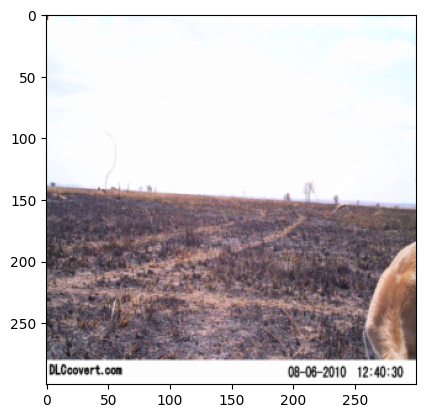

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

image = val_data[idx][0]

display_transformation = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], 
    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
    std = [ 1., 1., 1. ]),
    v2.ToPILImage(),
    ])

image = display_transformation(image)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# # Create a Rectangle patch
img_boxes = list(boxes[0][0])
box = [i.item() for i in img_boxes]
print(box)
x, y, w, h = box

rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

# # Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# TODO


- Training EfficientNet
- Region Proposal Network
- Cascade Classifier

* What is my niche? 
    * Integrate it yourself?
    * Use it for population predictions?

* Decide where to use WRS
* Choose what training Data to use:
    - Backbone(EfficientNet): ImageNet -> Bbox Images
    - Region Proposal Network: BBox Images
    - Cascade Classifier: Labelled images

In [ ]:
from torchvision import models
model = models.detection.FasterRCNN(pretrained = True)